# Semi_defect_finder
반도체 공정/계측 데이터 기반 **결함 여부(불량/정상)** 이진 분류 모델 구축 노트북


[Phase 1] 전처리 파이프라인
VarianceThreshold → 상관관계 제거 → ANOVA top-K

[Phase 2] 데이터 전략별 비교  (핵심 실험: Recall 값 비교)
XGBoost, LightGBM, RF, LR 모델들로
"Normal, Undersampled, SMOTE, PCA + 위 3개" 기법들로 적용 후 비교분석

[Phase 3] 이상치 탐지 (별도 프레임)
EE / IF / LOF → Recall 비교

[Phase 4] Top 3 모델 GridSearchCV 튜닝

[Phase 5] VotingClassifier 앙상블
Phase 2~4에서 Recall 상위 모델 조합





In [1]:
# =========================================
# 1) Imports (preprocess & modeling)
# =========================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from dataclasses import dataclass
from typing import List, Optional

from sklearn.model_selection import StratifiedKFold, GroupKFold, TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator, TransformerMixin



In [2]:
# # 김태훈
# import os
# os.chdir("/home/tae-hun-kim/바탕화면/AI모델개발/Semiconductor_Quality_Prospect")
# print("cwd:", os.getcwd())
# print("exists:", os.path.exists("SECOM/uci-secom.csv"))

In [3]:
# #최정빈
# import os
# os.chdir(r"C:/Users/0726b/Semiconductor_Quality_Prospect")  
# print("cwd:", os.getcwd())
# print("exists:", os.path.exists("SECOM/uci-secom.csv"))

In [4]:
# =========================================
# 2) Load data & basic checks
# =========================================

from pathlib import Path
import pandas as pd

# 프로젝트 루트(.git) 탐색
root = Path.cwd()
while root != root.parent and not (root / ".git").exists():
    root = root.parent

csv_path = root / "SECOM" / "uci-secom.csv"
print("Resolved csv_path:", csv_path)

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

target_col = "Defect"
tool_col = "Tool_Type"

print("Target col:", target_col)
print("Tool_Type col:", tool_col)

print("Missing ratio (top 10):")
print(df.isna().mean().sort_values(ascending=False).head(16))

df.head()


Resolved csv_path: /Users/parkjunbeom/Library/CloudStorage/GoogleDrive-yrtny70127@gmail.com/내 드라이브/Colab Notebooks/Github/Project_Semiconductor/Semiconductor_Quality_Prospect/SECOM/uci-secom.csv
Shape: (1567, 592)
Columns: ['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124'

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


Dropped Time: False


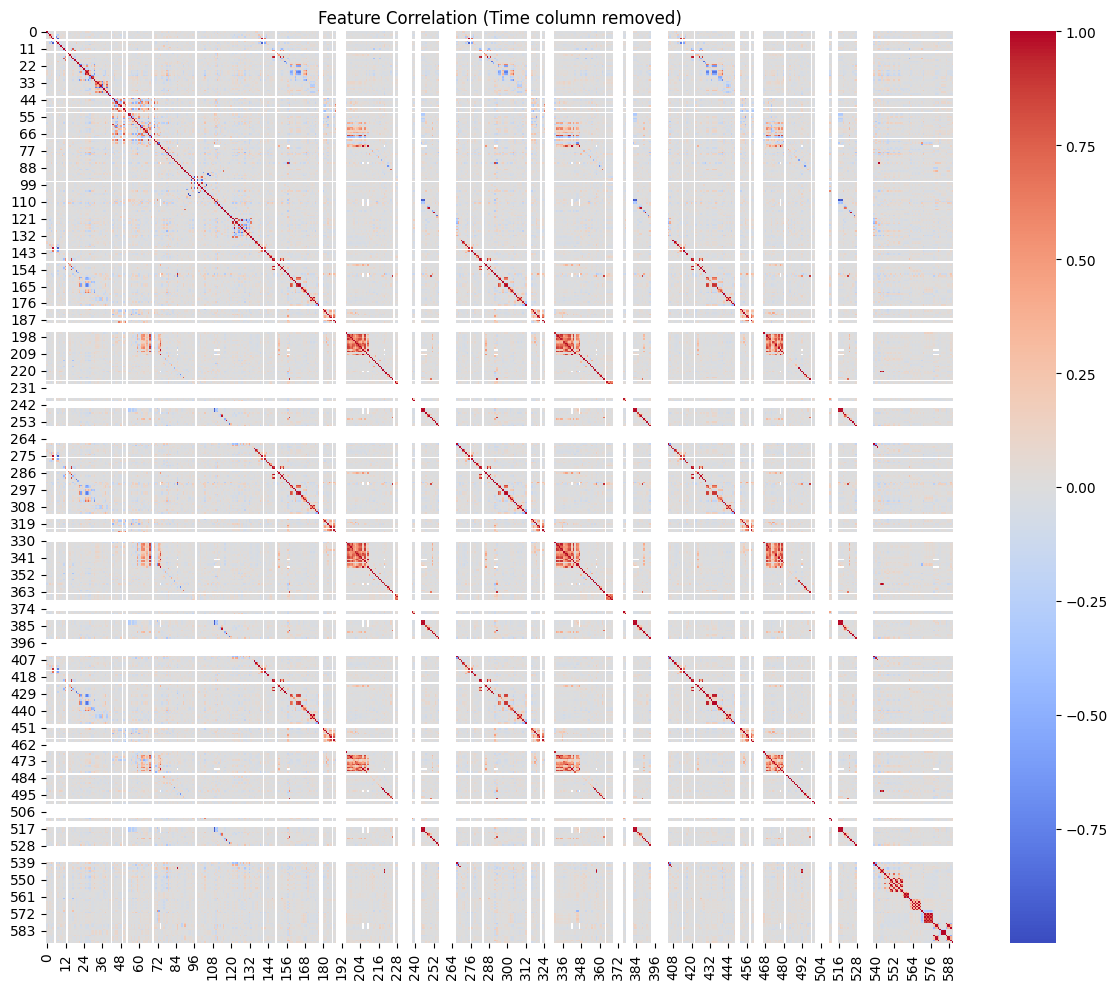

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [5]:
# =========================================
# 2-1) Drop Time column & correlation heatmap
# =========================================

df = df.drop(columns=["Time"], errors="ignore")
print("Dropped Time:", "Time" in df.columns)

# Numeric-only correlation
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (Time column removed)")
plt.tight_layout()
plt.show()

df.head()


### Time 제거 → 전부 NaN/분산 0 컬럼 제거 → 숫자형 상관계수 계산 → 히트맵으로 시각화.

all_nan: 0
zero_var: 116


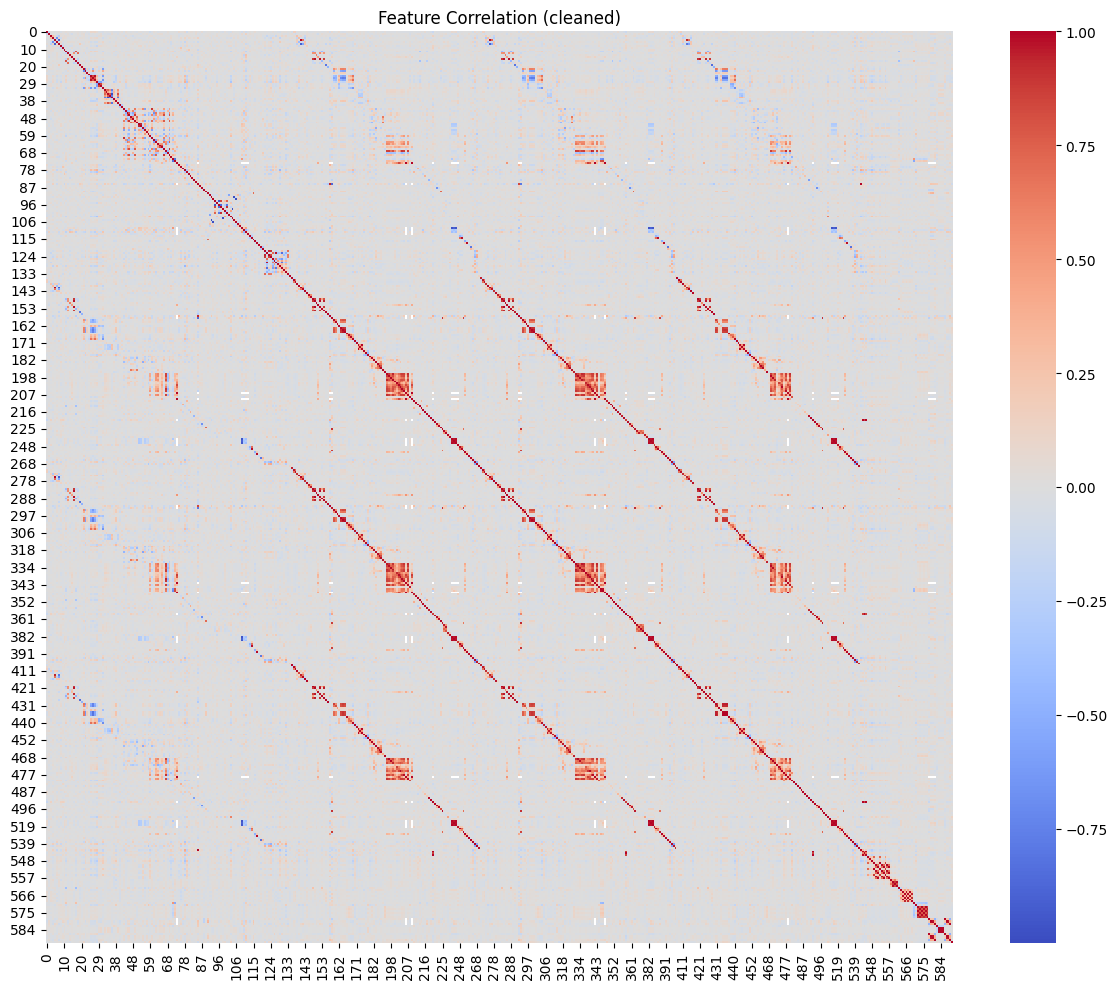

In [6]:
# df 기준
df = df.copy()

# 1) 전부 NaN 컬럼
all_nan_cols = df.columns[df.isna().all()].tolist()

# 2) 분산 0 컬럼 (값이 모두 동일)
zero_var_cols = df.columns[df.nunique(dropna=True) <= 1].tolist()

print("all_nan:", len(all_nan_cols))
print("zero_var:", len(zero_var_cols))

# 제거
drop_cols = sorted(set(all_nan_cols + zero_var_cols))
df = df.drop(columns=drop_cols)

# 다시 히트맵
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (cleaned)")
plt.tight_layout()
plt.show()


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 475 entries, 0 to Pass/Fail
dtypes: float64(474), int64(1)
memory usage: 5.7 MB


Drop count: 194
['27', '36', '96', '104', '105', '106', '127', '140', '148', '152', '165', '174', '206', '209', '244', '245', '246', '249', '252', '271', '272', '274', '275', '277', '279', '280', '281', '282', '283', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '317', '318', '319', '320', '321', '323', '324', '332', '333', '334', '335', '338', '339', '340', '341', '342', '343', '344', '346', '347', '349', '350', '351', '352', '353', '354', '355', '357', '359', '360', '361', '362', '363', '365', '366', '376', '377', '382', '383', '384', '386', '387', '388', '389', '390', '391', '392', '393', '405', '406', '407', '408', '409', '410', '411', '415', '416', '417', '420', '421', '424', '425', '426', '427', '428', '429', '435', '436', '437', '440', '441', '442', '443', '444', '445', '446', '447', '448', '452', '453', '454', '455', '456', '457',

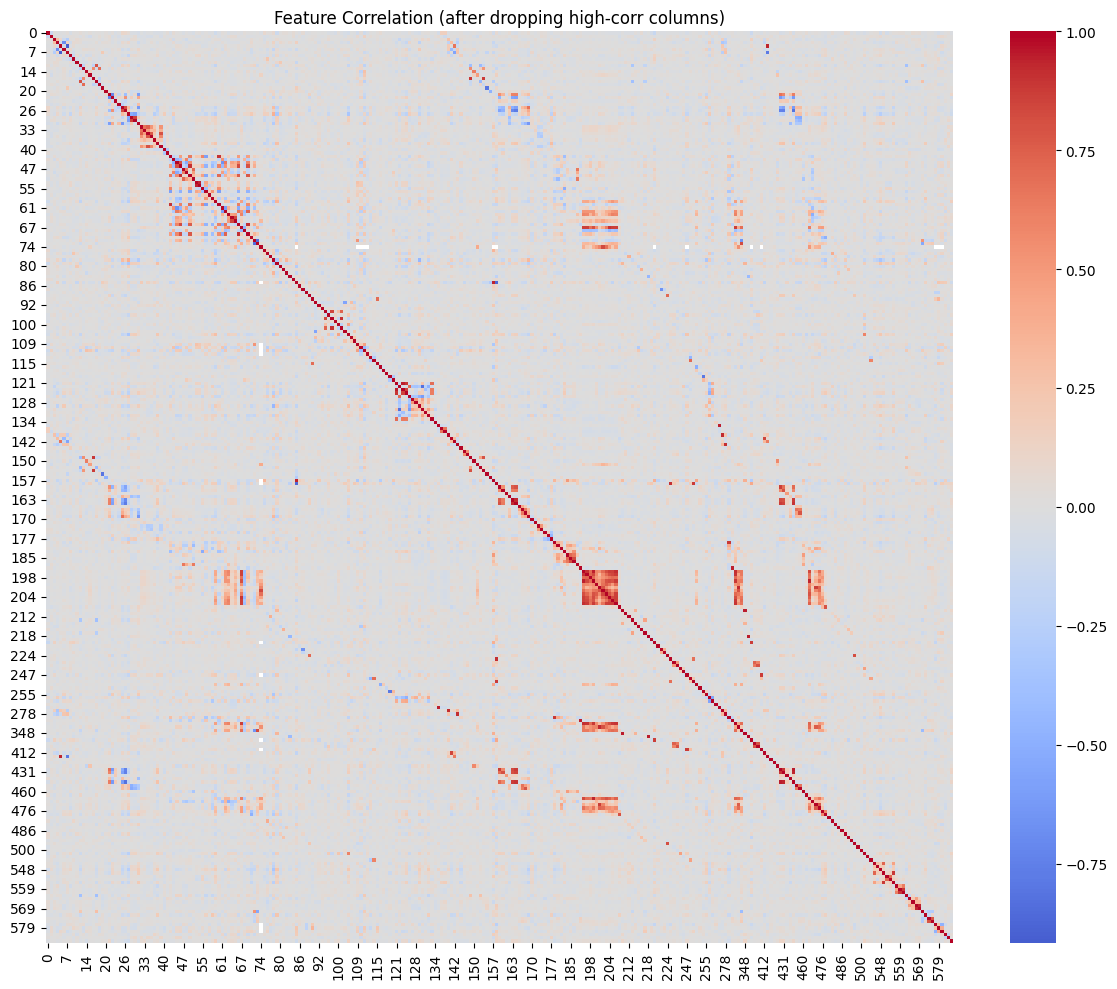

In [8]:
# 절댓값 상관계수 0.95 이상인 컬럼 제거
threshold = 0.95

# 숫자형만 상관계수
corr = df.select_dtypes(include=["number"]).corr().abs()

# 상삼각행렬만 사용 (중복 제거)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 임계치 초과 컬럼 선택
to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]

print("Drop count:", len(to_drop))

# 필요하면 목록 확인
print(to_drop)

df = df.drop(columns=to_drop)

df.info()
df.head()

# 제거 후 히트맵
corr_after = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_after, cmap="coolwarm", center=0)
plt.title("Feature Correlation (after dropping high-corr columns)")
plt.tight_layout()
plt.show()

In [9]:
# Pass/Fail을 0/1로 변환 (-1: Pass -> 0, 1: Fail -> 1)
df["Pass/Fail"] = df["Pass/Fail"].map({-1: 0, 1: 1})

df.head(20)

,0,1,2,3,4,6,7,8,9,10,...,570,571,572,573,578,579,581,582,583,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,533.8500,2.1113,8.9500,0.3157,NaN,NaN,NaN,0.5005,0.0118,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,535.0164,2.4335,5.9200,0.2653,0.0096,0.0201,208.2045,0.5019,0.0223,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,535.0245,2.0293,11.2100,0.1882,0.0584,0.0484,82.8602,0.4958,0.0157,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,530.5682,2.0253,9.3300,0.1738,0.0202,0.0149,73.8432,0.4990,0.0103,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,532.0155,2.0275,8.8300,0.2224,NaN,NaN,NaN,0.4800,0.4766,0
5,2946.25,2432.84,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5287,0.0167,0.0055,...,534.2091,2.3236,8.9100,0.3201,0.0342,0.0151,44.0077,0.4949,0.0189,0
6,3030.27,2430.12,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.5816,-0.0270,0.0105,...,541.9036,2.4229,6.4800,0.2027,NaN,NaN,NaN,0.5010,0.0143,0
7,3058.88,2690.15,2248.9000,1004.4692,0.7884,106.2400,0.1185,1.5153,0.0157,0.0007,...,493.0054,2.2008,278.1900,0.3540,0.0204,0.0194,95.0310,0.4984,0.0106,0
8,2967.68,2600.47,2248.9000,1004.4692,0.7884,106.2400,0.1185,1.5358,0.0111,-0.0066,...,535.1818,2.2170,7.0900,0.3168,0.0111,0.0124,111.6525,0.4993,0.0172,0
9,3016.11,2428.37,2248.9000,1004.4692,0.7884,106.2400,0.1185,1.5381,0.0159,0.0049,...,533.4200,2.2598,3.5400,0.1676,0.0212,0.0191,90.2294,0.4967,0.0152,0


158    0.911934
157    0.911934
220    0.855775
85     0.855775
358    0.855775
109    0.649649
111    0.649649
110    0.649649
581    0.605616
579    0.605616
578    0.605616
345    0.506701
73     0.506701
72     0.506701
247    0.456286
112    0.456286
385    0.456286
565    0.174218
569    0.174218
564    0.174218
563    0.174218
562    0.174218
548    0.165922
546    0.165922
547    0.165922
549    0.165922
551    0.165922
555    0.165922
550    0.165922
90     0.032546
dtype: float64


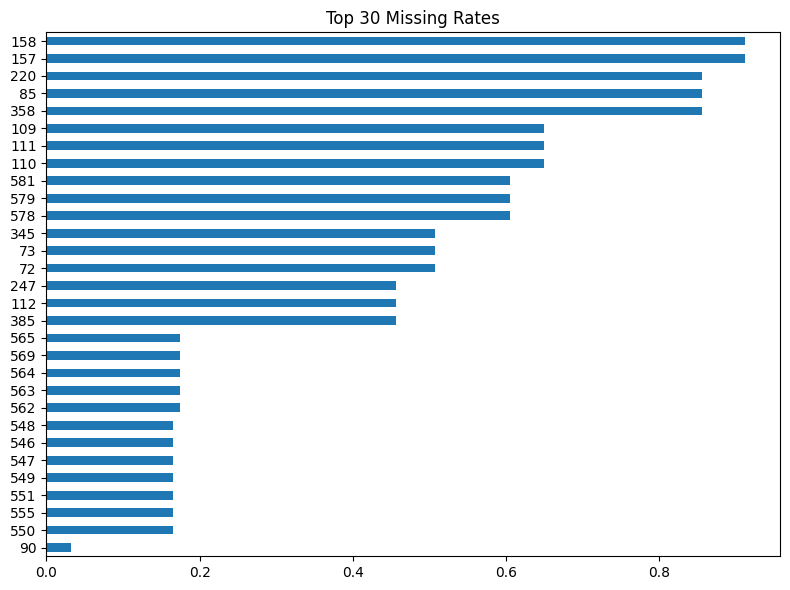

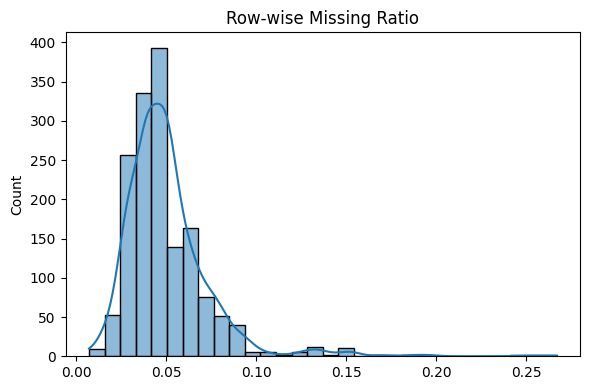

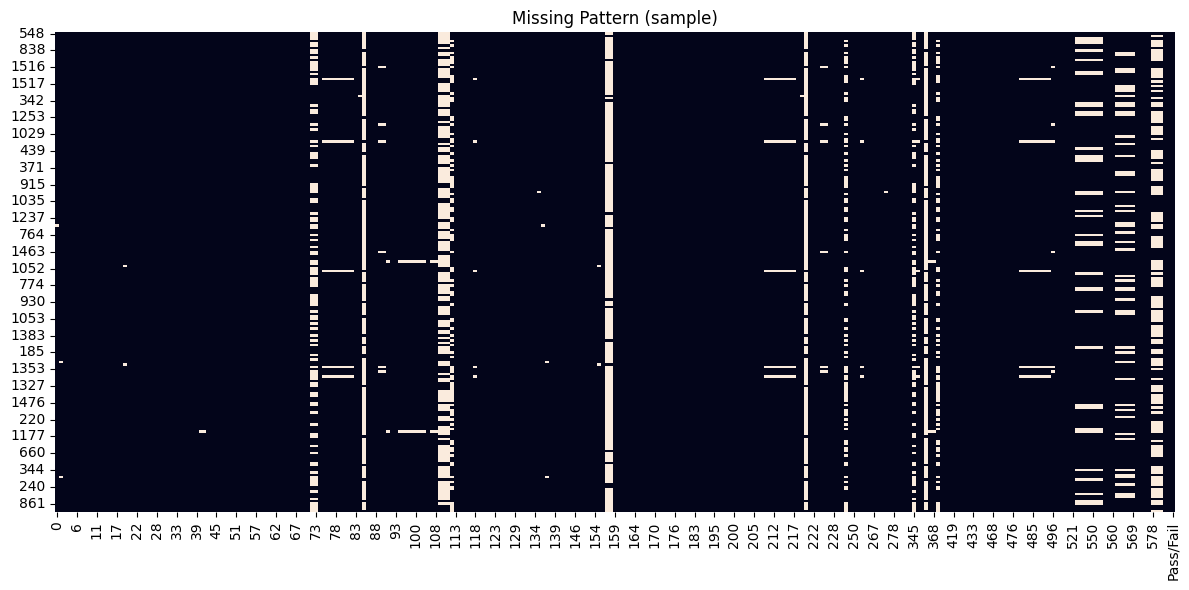

                  0         1         2         3         4         6  \
Pass/Fail                                                               
0          0.004101  0.004101  0.009569  0.009569  0.009569  0.009569   
1          0.000000  0.009615  0.000000  0.000000  0.000000  0.000000   

                  7         8         9        10  ...  570  571  572  573  \
Pass/Fail                                          ...                       
0          0.006152  0.001367  0.001367  0.001367  ...  0.0  0.0  0.0  0.0   
1          0.000000  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   

                578       579       581       582       583  Pass/Fail  
Pass/Fail                                                               
0          0.608339  0.608339  0.608339  0.000684  0.000684        0.0  
1          0.567308  0.567308  0.567308  0.000000  0.000000        0.0  

[2 rows x 281 columns]


In [10]:

# 1) 컬럼별 결측률 상위 30개
missing_rate = df.isna().mean().sort_values(ascending=False)
print(missing_rate.head(30))

plt.figure(figsize=(8, 6))
missing_rate.head(30).plot(kind="barh")
plt.title("Top 30 Missing Rates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2) 행별 결측률 분포
row_missing = df.isna().mean(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(row_missing, bins=30, kde=True)
plt.title("Row-wise Missing Ratio")
plt.tight_layout()
plt.show()

# 3) 결측 패턴 히트맵 (샘플 200행)
sample = df.sample(min(200, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Pattern (sample)")
plt.tight_layout()
plt.show()

# 4) 타깃별 결측률 비교 (Pass/Fail 컬럼이 있을 때)
if "Pass/Fail" in df.columns:
    missing_by_target = df.groupby("Pass/Fail").apply(lambda x: x.isna().mean())
    print(missing_by_target.head())


In [11]:
# 결측률 0.5 이상 컬럼 제거
threshold = 0.5
missing_rate = df.isna().mean()
drop_cols = missing_rate[missing_rate >= threshold].index.tolist()

print("Drop count:", len(drop_cols))
print(drop_cols)

df = df.drop(columns=drop_cols)

# 확인
df.info()


Drop count: 14
['72', '73', '85', '109', '110', '111', '157', '158', '220', '345', '358', '578', '579', '581']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 267 entries, 0 to Pass/Fail
dtypes: float64(266), int64(1)
memory usage: 3.2 MB


385    0.456286
112    0.456286
247    0.456286
569    0.174218
562    0.174218
563    0.174218
564    0.174218
565    0.174218
555    0.165922
546    0.165922
547    0.165922
548    0.165922
549    0.165922
550    0.165922
551    0.165922
225    0.032546
496    0.032546
224    0.032546
90     0.032546
89     0.032546
253    0.015316
80     0.015316
81     0.015316
211    0.015316
212    0.015316
213    0.015316
214    0.015316
215    0.015316
216    0.015316
217    0.015316
dtype: float64


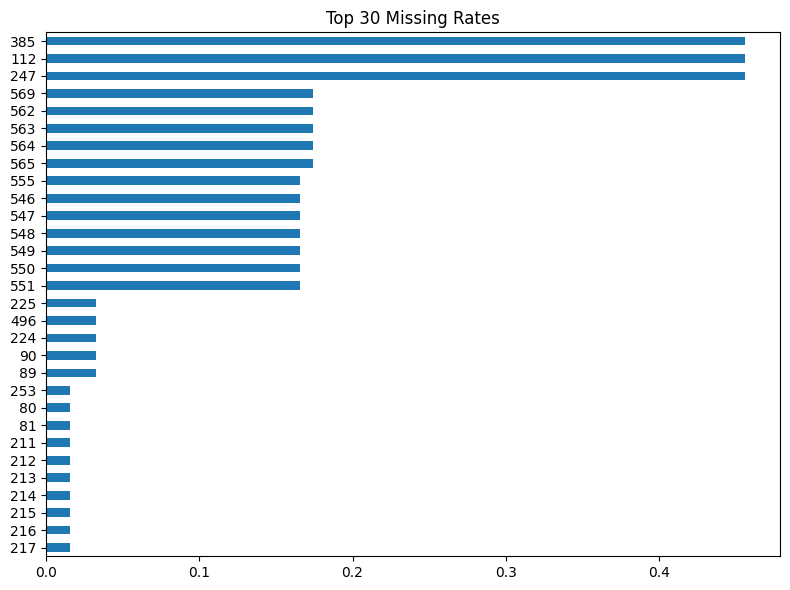

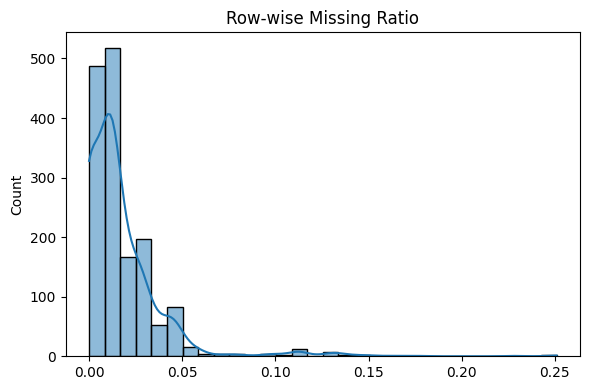

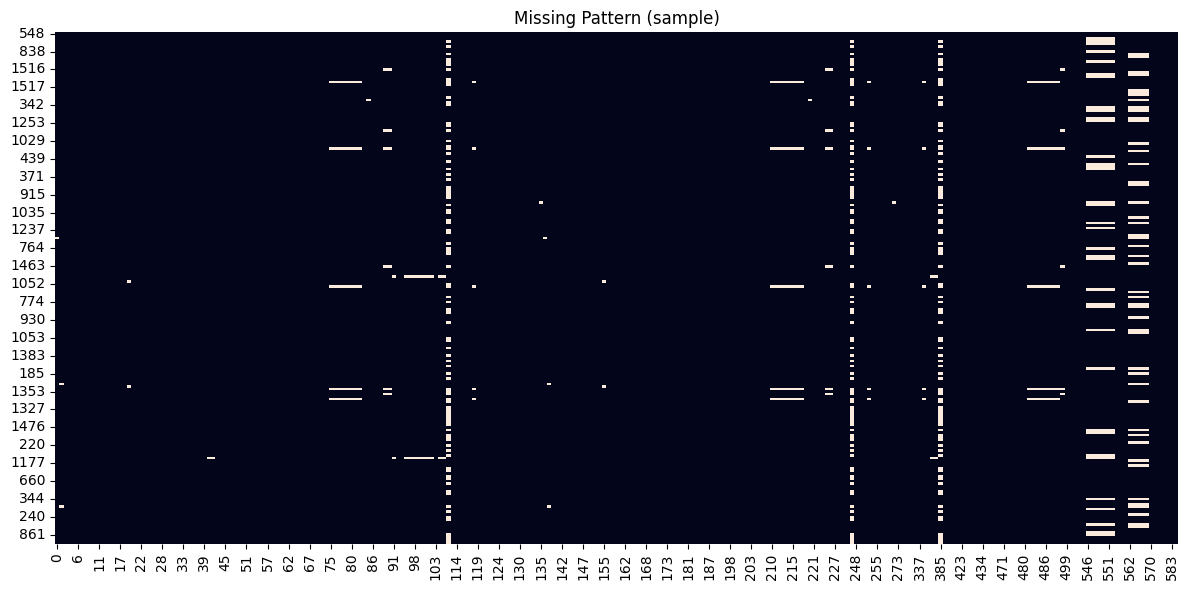

                  0         1         2         3         4         6  \
Pass/Fail                                                               
0          0.004101  0.004101  0.009569  0.009569  0.009569  0.009569   
1          0.000000  0.009615  0.000000  0.000000  0.000000  0.000000   

                  7         8         9        10  ...       564       565  \
Pass/Fail                                          ...                       
0          0.006152  0.001367  0.001367  0.001367  ...  0.170198  0.170198   
1          0.000000  0.000000  0.000000  0.000000  ...  0.230769  0.230769   

                569  570  571  572  573       582       583  Pass/Fail  
Pass/Fail                                                               
0          0.170198  0.0  0.0  0.0  0.0  0.000684  0.000684        0.0  
1          0.230769  0.0  0.0  0.0  0.0  0.000000  0.000000        0.0  

[2 rows x 267 columns]


In [12]:
# 1) 컬럼별 결측률 상위 30개
missing_rate = df.isna().mean().sort_values(ascending=False)
print(missing_rate.head(30))

plt.figure(figsize=(8, 6))
missing_rate.head(30).plot(kind="barh")
plt.title("Top 30 Missing Rates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2) 행별 결측률 분포
row_missing = df.isna().mean(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(row_missing, bins=30, kde=True)
plt.title("Row-wise Missing Ratio")
plt.tight_layout()
plt.show()

# 3) 결측 패턴 히트맵 (샘플 200행)
sample = df.sample(min(200, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Pattern (sample)")
plt.tight_layout()
plt.show()

# 4) 타깃별 결측률 비교 (Pass/Fail 컬럼이 있을 때)
if "Pass/Fail" in df.columns:
    missing_by_target = df.groupby("Pass/Fail").apply(lambda x: x.isna().mean())
    print(missing_by_target.head())


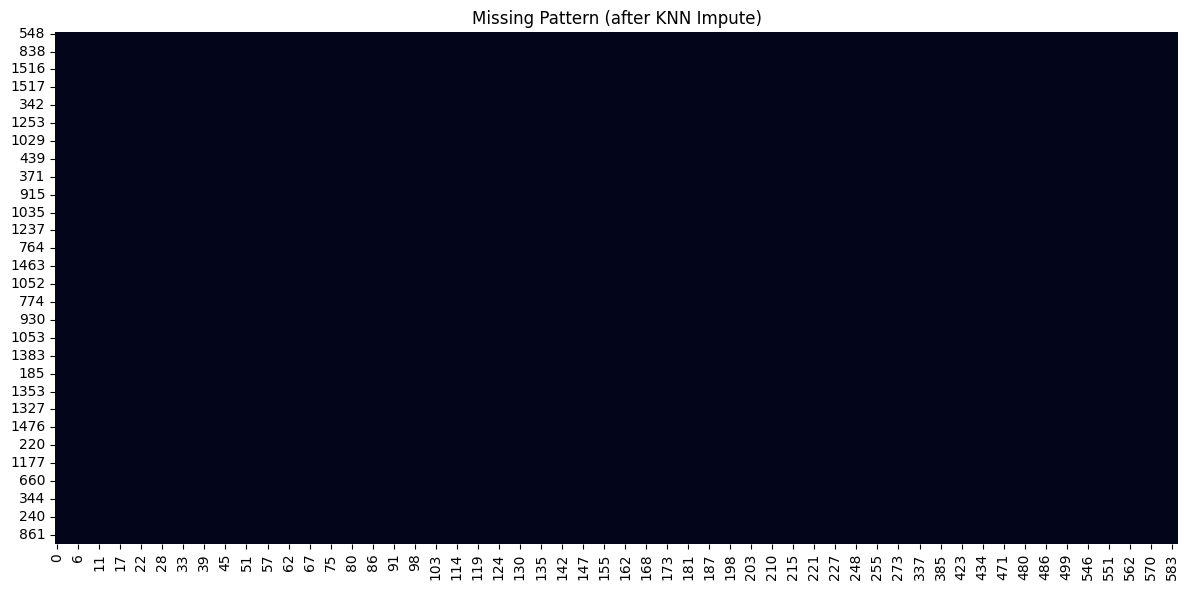

In [14]:
target = "Pass/Fail"
X = df.drop(columns=[target])

from sklearn.impute import KNNImputer

# KNN Imputer 적용
imputer = KNNImputer(n_neighbors=5, weights="distance")
X_imputed = imputer.fit_transform(X)

# 다시 DataFrame으로
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# KNN으로 채운 결과를 df로 합치기
df = df.copy()
df[X.columns] = X_imputed  # X에 해당하는 컬럼만

# 3) 결측 패턴 히트맵 (샘플 200행)
sample = df.sample(min(200, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Pattern (after KNN Impute)")
plt.tight_layout()
plt.show()



# Visualization

In [ ]:
# 1) 컬럼 타입 분리
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

# 2) 숫자형: 분산 큰 Top 10 (분포/박스플롯 추천)
num_var = df[num_cols].var().sort_values(ascending=False)
print("\nTop variance numeric cols:")
print(num_var.head(10))

# 3) 숫자형: 왜도 큰 Top 10 (로그변환 전/후 비교 추천)
num_skew = df[num_cols].skew().sort_values(ascending=False)
print("\nTop skew numeric cols:")
print(num_skew.head(10))

# 4) 결측률 높은 컬럼 Top 10 (결측 패턴/타깃 비교 추천)
missing_rate = df.isna().mean().sort_values(ascending=False)
print("\nTop missing rate cols:")
print(missing_rate.head(10))

# 5) 상관 높은 컬럼 쌍 Top 10 (산점도 추천)
corr = df[num_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .head(10)
)
print("\nTop correlated pairs:")
print(high_corr_pairs)

# 6) 범주형: 값 개수 많은 Top 10 (막대그래프/파이 추천)
if cat_cols:
    cat_card = df[cat_cols].nunique().sort_values(ascending=False)
    print("\nTop cardinality categorical cols:")
    print(cat_card.head(10))


Numeric cols: 281
Categorical cols: 0

Top variance numeric cols:
162    4.290777e+07
161    1.795221e+07
24     8.416601e+06
23     1.902630e+06
159    9.651971e+05
21     3.925492e+05
160    3.300041e+05
204    3.181198e+05
3      1.943428e+05
225    1.822486e+05
dtype: float64

Top skew numeric cols:
74     39.585351
117    38.005963
16     37.070259
185    30.707863
147    29.444846
154    27.729825
202    24.727860
187    24.516253
583    24.416941
551    22.753810
dtype: float64

Top missing rate cols:
0      0.0
227    0.0
250    0.0
248    0.0
247    0.0
239    0.0
238    0.0
228    0.0
225    0.0
253    0.0
dtype: float64

Top correlated pairs:
218  356    0.949915
210  348    0.949837
430  434    0.948041
135  270    0.946507
195  331    0.945299
121  123    0.942228
196  199    0.941970
565  569    0.939564
4    413    0.938377
199  471    0.938272
dtype: float64


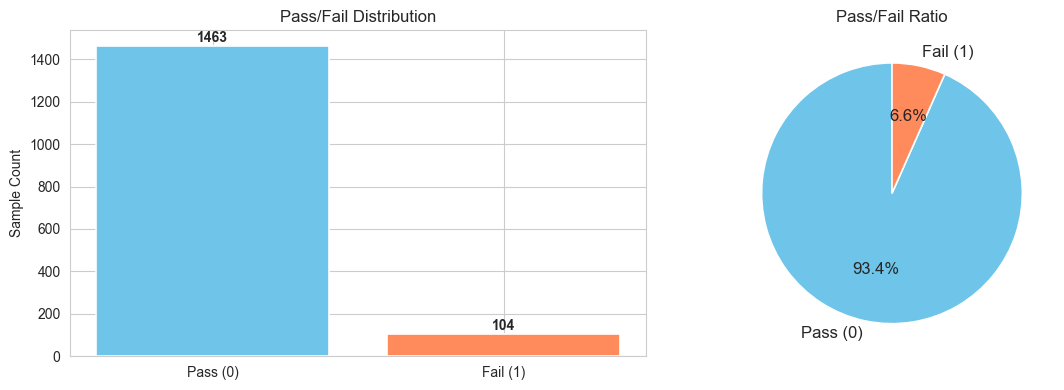

Pass: 1463 (93.4%)
Fail: 104 (6.6%)
Imbalance ratio: 1:14


In [ ]:
# =========================================
# 4) Target Distribution (Pass/Fail Ratio) - Pastel Style
# =========================================
counts = df['Pass/Fail'].value_counts().sort_index()
labels = ['Pass (0)', 'Fail (1)']
colors = ['#6EC5E9', '#FF8A5B']  # 파스텔 블루/코랄

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar
axes[0].bar(labels, counts.values, color=colors, edgecolor='white', linewidth=1.2)
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 20, f'{v}', ha='center', fontweight='bold')
axes[0].set_ylabel('Sample Count')
axes[0].set_title('Pass/Fail Distribution')

# Pie
axes[1].pie(
    counts.values,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.2},
    textprops={'fontsize': 12}
)
axes[1].set_title('Pass/Fail Ratio')

plt.tight_layout()
plt.show()

print(f'Pass: {counts.iloc[0]} ({counts.iloc[0]/len(df)*100:.1f}%)')
print(f'Fail: {counts.iloc[1]} ({counts.iloc[1]/len(df)*100:.1f}%)')
print(f'Imbalance ratio: 1:{counts.iloc[0]//counts.iloc[1]}')


In [ ]:
X = df.drop(columns=['Pass/Fail'])
y = df['Pass/Fail']

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


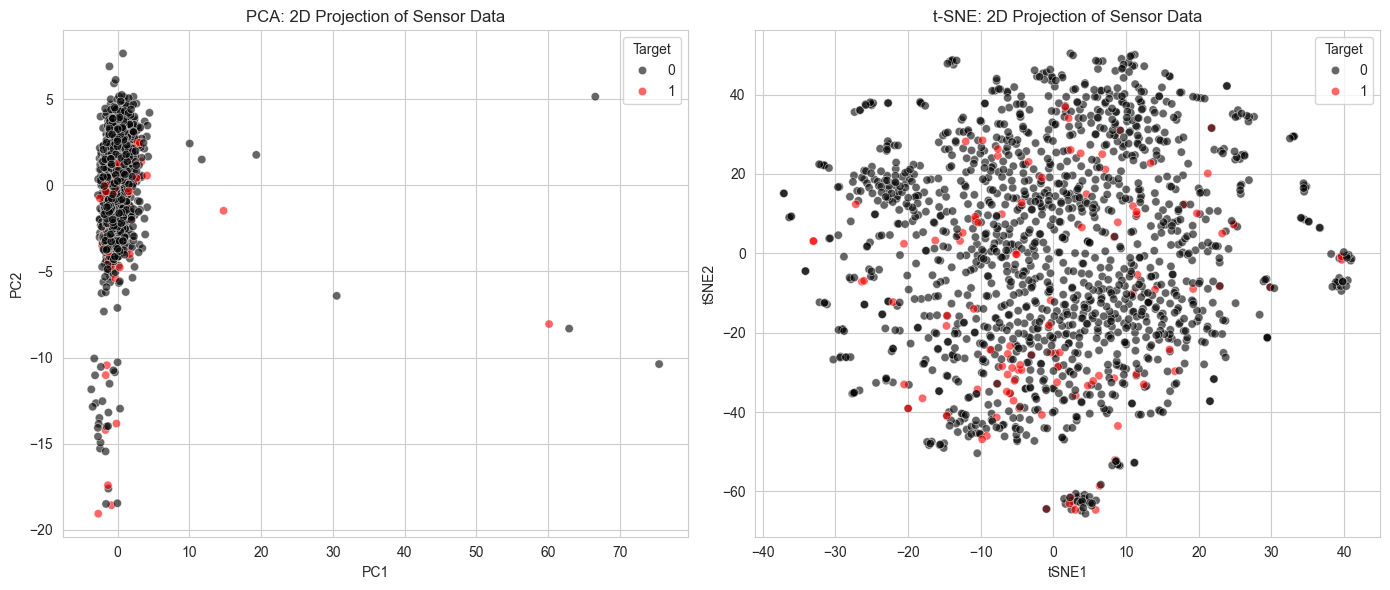

In [ ]:
# PCA + t-SNE 한 줄(1x2)로 출력
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = y.values

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
tsne_df['Target'] = y.values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Target',
                alpha=0.6, palette={-1: 'blue', 1: 'red'}, ax=axes[0])
axes[0].set_title('PCA: 2D Projection of Sensor Data')

sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Target',
                alpha=0.6, palette={-1: 'blue', 1: 'red'}, ax=axes[1])
axes[1].set_title('t-SNE: 2D Projection of Sensor Data')

plt.tight_layout()
plt.show()


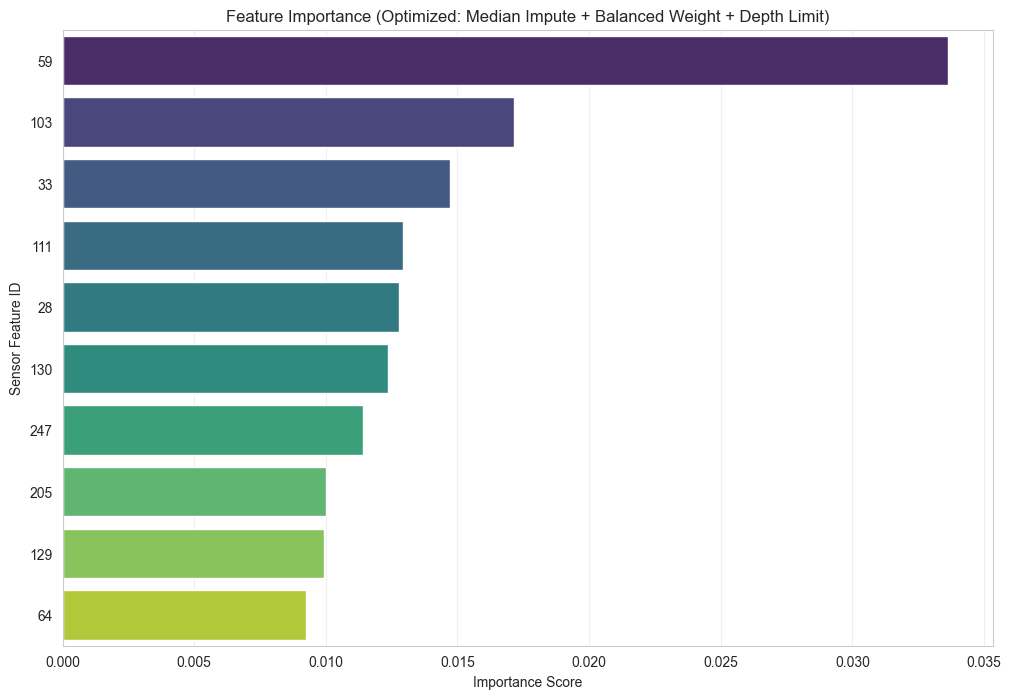

=== Top 10 Critical Sensors ===
59     0.033643
103    0.017140
33     0.014716
111    0.012951
28     0.012789
130    0.012358
247    0.011421
205    0.010003
129    0.009915
64     0.009248
dtype: float64


In [ ]:
# RandomForestClassifier 최적화된 피처 중요도 시각화

imputer = SimpleImputer(strategy='median') # 중앙값(Median) 대치
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

selector = VarianceThreshold(threshold=0)
X_clean = pd.DataFrame(selector.fit_transform(X_imputed), columns=X_imputed.columns[selector.get_support()])

rf_best = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)

rf_best.fit(X_clean, y)

importances = pd.Series(rf_best.feature_importances_, index=X_clean.columns)
top_features = importances.nlargest(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index.astype(str), palette='viridis')

plt.title('Feature Importance (Optimized: Median Impute + Balanced Weight + Depth Limit)')
plt.xlabel('Importance Score')
plt.ylabel('Sensor Feature ID')
plt.grid(axis='x', alpha=0.3)
plt.show()

# 상위 10개 출력
print("=== Top 10 Critical Sensors ===")
print(top_features.head(10))

#

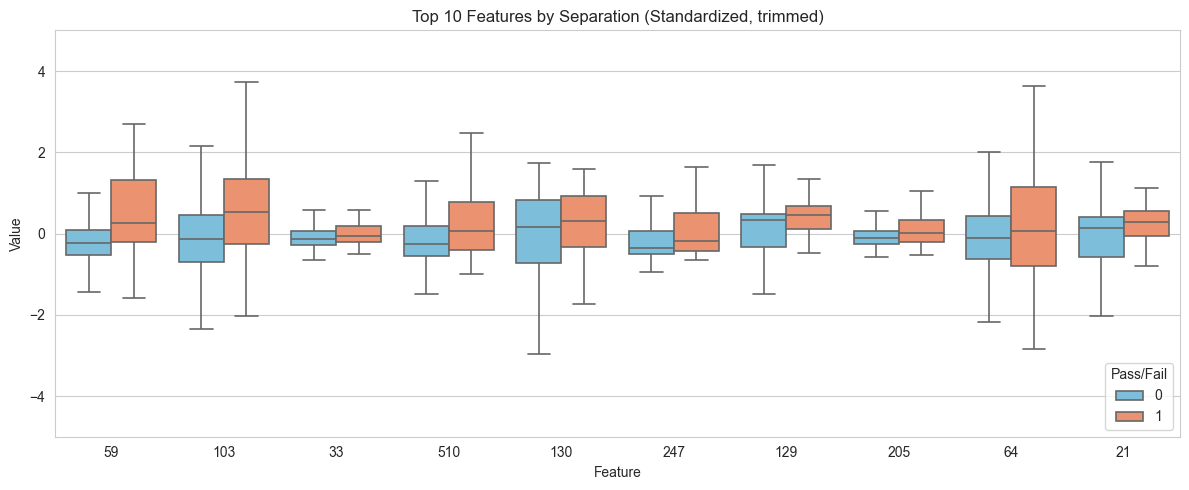

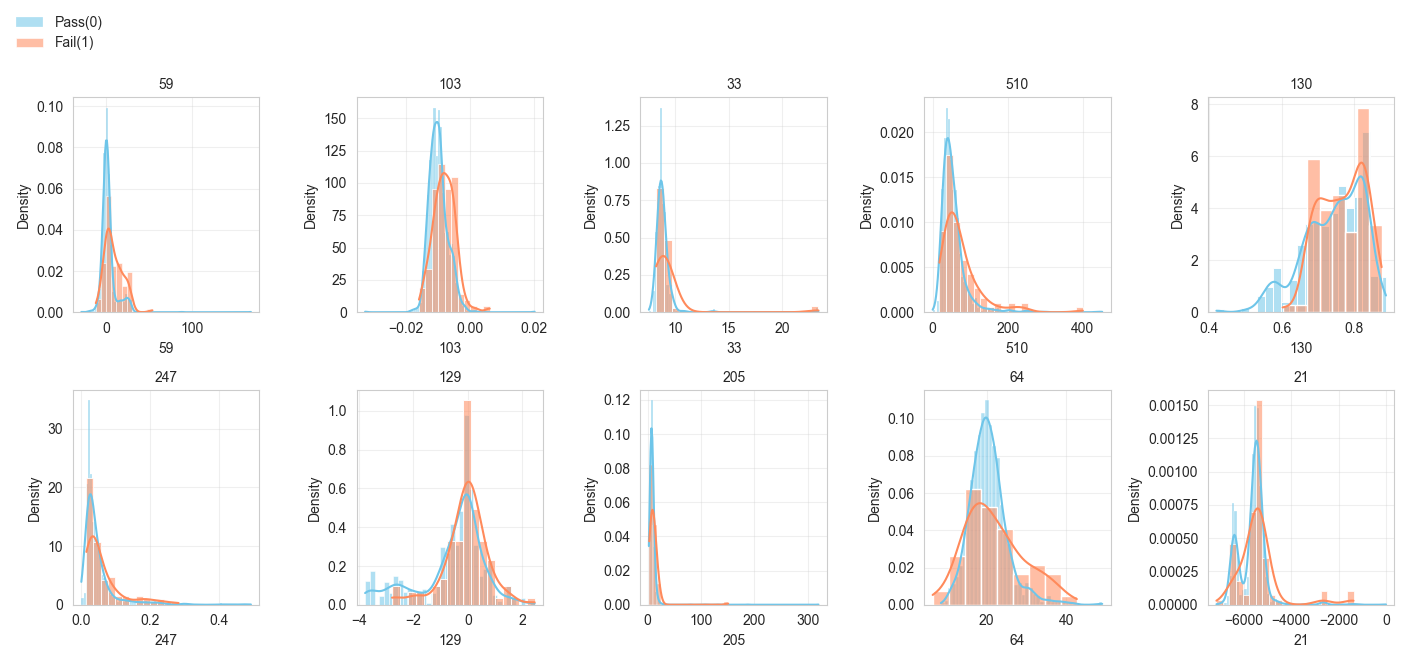

In [ ]:
sns.set_style("whitegrid")

target = "Pass/Fail"
top10 = ["59","103","33","510","130","247","129","205","64","21"]
palette_pf = {0: "#6EC5E9", 1: "#FF8A5B", "0": "#6EC5E9", "1": "#FF8A5B"}

# =========================
# 1) 박스플롯 (표준화 + 더 잘 보이게)
# =========================
df_std = df.copy()
df_std[top10] = (df_std[top10] - df_std[top10].mean()) / df_std[top10].std()

df_melt = df_std.melt(id_vars=target, value_vars=top10, var_name="Feature", value_name="Value")

plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df_melt,
    x="Feature",
    y="Value",
    hue=target,
    palette=palette_pf,
    linewidth=1.2,
    fliersize=0,          # 이상치 점 숨김
    whis=1.5
)

ymin, ymax = df_melt["Value"].quantile([0.005, 0.995])
plt.ylim(-5, 5)



plt.title("Top 10 Features by Separation (Standardized, trimmed)")
plt.tight_layout()
plt.show()


# =========================
# 2) 히스토그램 (범례 그래프 밖으로)
# =========================
g0 = df[df[target].astype(str) == "0"]
g1 = df[df[target].astype(str) == "1"]

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for ax, col in zip(axes.flatten(), top10):
    sns.histplot(g0[col], color="#6EC5E9", label="Pass(0)", kde=True,
                 ax=ax, stat="density", alpha=0.55)
    sns.histplot(g1[col], color="#FF8A5B", label="Fail(1)", kde=True,
                 ax=ax, stat="density", alpha=0.55)
    ax.set_title(str(col), fontsize=10)
    ax.grid(alpha=0.3)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left",
           bbox_to_anchor=(0.001, 1.1), frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # 오른쪽 여백 확보
plt.show()

# 통계적으로 유의미한 차이 확인 상관계수를 보던지 어떤 컬럼이 중요한지 분석 필요 기준이 없어 일반적으로 상관계수로 함

 # Train / Test data 분리


In [ ]:
target = "Pass/Fail"
X = df.drop(columns=[target])
y = df[target].astype(int)

# 1) 먼저 분리
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 2) Train으로만 피처 선택
k = 20
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("anova", SelectKBest(score_func=f_classif, k=k))
])
pipe.fit(X_train, y_train)

selected_cols = X_train.columns[pipe.named_steps["anova"].get_support()]

# 3) Train/Valid/Test 모두 동일 컬럼만 유지
X_train = X_train[selected_cols]
X_valid = X_valid[selected_cols]
X_test  = X_test[selected_cols]

print("Selected features:", selected_cols.tolist())
print("Train:", X_train.shape)
print("Valid:", X_valid.shape)
print("Test :", X_test.shape)


Selected features: ['14', '21', '22', '28', '59', '63', '64', '95', '103', '124', '125', '129', '205', '210', '316', '348', '430', '431', '434', '510']
Train: (1096, 20)
Valid: (235, 20)
Test : (236, 20)


# MODELING

In [ ]:
models = {
    "Logistic": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestClassifier(
            n_estimators=300, max_depth=12, random_state=42,
            n_jobs=-1, class_weight="balanced"
        ))
    ]),
    "HistGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingClassifier(
            max_depth=8, learning_rate=0.05, random_state=42
        ))
    ])
}

In [ ]:

def eval_model(name, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_va)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return {
        "model": name,
        "ROC-AUC": roc_auc_score(y_va, proba),
        "PR-AUC": average_precision_score(y_va, proba),
        "Precision": precision_score(y_va, pred, zero_division=0),
        "Recall": recall_score(y_va, pred, zero_division=0),
        "F1": f1_score(y_va, pred, zero_division=0)
    }

results = []
for name, model in models.items():
    results.append(eval_model(name, model, X_train, y_train, X_valid, y_valid))

pd.DataFrame(results).sort_values("PR-AUC", ascending=False)


,model,ROC-AUC,PR-AUC,Precision,Recall,F1
0,Logistic,0.819697,0.279580,0.147059,0.666667,0.240964
1,RandomForest,0.820606,0.228605,1.000000,0.066667,0.125000
2,HistGB,0.756970,0.198341,1.000000,0.066667,0.125000


In [ ]:

def find_best_threshold(model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_va)[:, 1]

    thresholds = np.linspace(0.01, 0.99, 99)
    best_f1 = (0, 0, 0)   # (thr, f1, recall)
    best_rec = (0, 0, 0)  # (thr, recall, precision)

    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        f1 = f1_score(y_va, pred, zero_division=0)
        rec = recall_score(y_va, pred, zero_division=0)
        prec = precision_score(y_va, pred, zero_division=0)

        if f1 > best_f1[1]:
            best_f1 = (thr, f1, rec)
        if rec > best_rec[1]:
            best_rec = (thr, rec, prec)

    return best_f1, best_rec

# 3개 모델 전체 검토
for name, model in models.items():
    best_f1, best_rec = find_best_threshold(model, X_train, y_train, X_valid, y_valid)
    print(f"\n{name}")
    print(f"  [Best F1]    thr={best_f1[0]:.2f}, F1={best_f1[1]:.3f}, Recall={best_f1[2]:.3f}")
    print(f"  [Best Recall] thr={best_rec[0]:.2f}, Recall={best_rec[1]:.3f}, Precision={best_rec[2]:.3f}")



Logistic
  [Best F1]    thr=0.66, F1=0.378, Recall=0.467
  [Best Recall] thr=0.01, Recall=1.000, Precision=0.064

RandomForest
  [Best F1]    thr=0.06, F1=0.273, Recall=1.000
  [Best Recall] thr=0.01, Recall=1.000, Precision=0.068

HistGB
  [Best F1]    thr=0.04, F1=0.245, Recall=0.400
  [Best Recall] thr=0.01, Recall=0.867, Precision=0.124


ROC-AUC: 0.7301136363636364
PR-AUC : 0.25449340248162833
              precision  recall  f1-score     support
0                  94.9    92.3      93.5  220.000000
1                  22.7    31.2      26.3   16.000000
accuracy           88.1    88.1      88.1    0.881356
macro avg          58.8    61.8      59.9  236.000000
weighted avg       90.0    88.1      89.0  236.000000
Confusion Matrix:
 [[203  17]
 [ 11   5]]


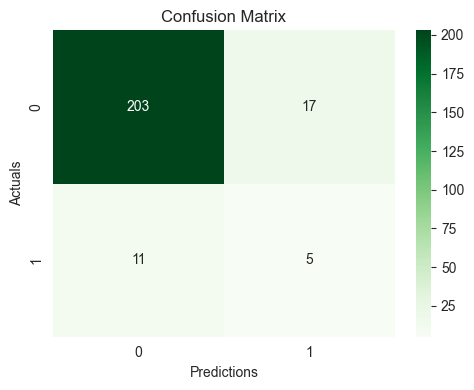

In [ ]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

best_name = "RandomForest"
best_thr = 0.16

model = models[best_name]
model.fit(X_train, y_train)
proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

# 퍼센트로 출력
report = classification_report(y_test, pred, output_dict=True)
df_report = pd.DataFrame(report).T
for col in ["precision", "recall", "f1-score"]:
    df_report[col] = (df_report[col] * 100).round(1)

print(df_report[["precision","recall","f1-score","support"]])

# Confusion Matrix 출력/시각화
cm = confusion_matrix(y_test, pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Greens",
    xticklabels=["0", "1"], yticklabels=["0", "1"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

best_name = "RandomForest"
model = models[best_name]

model.fit(X_train, y_train)
proba = model.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0.01, 0.99, 99)
best = {"thr": None, "f1": -1, "prec": 0, "rec": 0}

for thr in thresholds:
    pred = (proba >= thr).astype(int)
    f1 = f1_score(y_valid, pred, zero_division=0)
    if f1 > best["f1"]:
        best["thr"] = thr
        best["f1"] = f1
        best["prec"] = precision_score(y_valid, pred, zero_division=0)
        best["rec"] = recall_score(y_valid, pred, zero_division=0)

print("Best threshold by F1:", best)
print("PR-AUC (model only):", average_precision_score(y_valid, proba))


Best threshold by F1: {'thr': np.float64(0.060000000000000005), 'f1': 0.2727272727272727, 'prec': 0.15789473684210525, 'rec': 1.0}
PR-AUC (model only): 0.22860458417813156
